In [72]:
%%capture
%load_ext autoreload
%load_ext tikzmagic
%autoreload 2
import sys
sys.path.append("..")
import numpy as np

#reveal configuration
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'theme': 'white',
        'transition': 'none',
        'controls': 'false',
        'progress': 'true',
})

{'controls': 'false',
 'progress': 'true',
 'start_slideshow_at': 'selected',
 'theme': 'white',
 'transition': 'none'}

In [46]:
%%html
<style>
.red { color: #E41A1C; }
.orange { color: #FF7F00 }
.yellow { color: #FFC020 }         
.green { color: #4DAF4A }                  
.blue { color: #377EB8; }
.purple { color: #984EA3 } 
         
       
.left {
    float: left;
    width: 50%;
    vertical-align: text-top;
}

.right {
    margin-left: 50%;
    vertical-align: text-top;                            
}    
               
.small {         
    zoom: 0.9;
    -ms-zoom: 0.9;
    -webkit-zoom: 0.9;
    -moz-transform:  scale(0.9,0.9);
    -moz-transform-origin: left center;  
}          
         
.verysmall {         
    zoom: 0.75;
    -ms-zoom: 0.75;
    -webkit-zoom: 0.75;
    -moz-transform:  scale(0.75,0.75);
    -moz-transform-origin: left center;  
}         
   
        
.tiny {         
    zoom: 0.6;
    -ms-zoom: 0.6;
    -webkit-zoom: 0.6;
    -moz-transform:  scale(0.6,0.6);
    -moz-transform-origin: left center;  
}                

# Deep Learning for Natural Language Processing

## Motivation
The state-of-the-art in many NLP tasks is currently held by deep neural networks. Many NLP pipelines in industry are currently being replaced by deep neural networks. 
- [Google's Machine Translation](https://blog.google/products/translate/found-translation-more-accurate-fluent-sentences-google-translate/)
- [Question Answering](http://uclmr.github.io/ai4exams/results.html)
- [Natural Language Inference](http://nlp.stanford.edu/projects/snli/)
- ...


## Outline
- Backpropagation and Stochastic Gradient Descent
- A Modular Approach
  - Linear Algebra Operations
  - Activation Functions
  - Gradient Checking
- TensorFlow: A Deep Learning Library
- Regularization
  - Dropout
  - Gradient Clipping
- Recurrent Neural Networks
  - Long Short-term Memory (LSTM)
  - Gated Recurrent Unit (GRU)
- Attention

# Backpropagation and Stochastic Gradient Descent

## Model

At the core of Deep Learning (or Representation Learning in general) are parameterized functions that are differentiable with respect to their parameters (and inputs). We represent them by $f_\theta$ where $\theta$ are parameters that we want to learn from training data $\mathcal{T}=\{(x_i,y_i)\}$. For example:

<span class=verysmall>
\begin{align}
&\text{Linear Regression} & f_\theta(\mathbf{x}) &= \mathbf{Wx} + \mathbf{b}\\ % && \text{with }\theta = \{\mathbf{W}, \mathbf{b}\}\\
&\text{Logistic Regression} & f_\theta(\mathbf{x}) &= \frac{1}{1 + e^{-(\mathbf{Wx} + \mathbf{b})}}\\ % && \text{with }\theta = \{\mathbf{W}, \mathbf{b}\}\\
&\text{3-layer Perceptron} & f_\theta(\mathbf{x}) &= \text{tanh}(\mathbf{W}_3\text{tanh}(\mathbf{W}_2\text{tanh}(\mathbf{W}_1\mathbf{x} + \mathbf{b}_1)+\mathbf{b}_2)+\mathbf{b}_3)% && \text{with }\theta = \{\mathbf{W}_1, \mathbf{W}_2, \mathbf{W}_3, \mathbf{b}_1, \mathbf{b}_2, \mathbf{b}_3\}
\end{align}
</span>

## Loss Functions
For training from data we need another function that measures how far a prediction $f_\theta(x)$ is away from some gold output $y$. A few examples are

\begin{align}
& \text{Squared Distance} & \mathcal{L}(f_\theta, x, y) &= ||f_\theta(x) - y||^2 \\
& \text{Logistic} & \mathcal{L}(f_\theta, x, y) &= \log(1 + f_\theta(yx)) \\
& \text{Hinge} & \mathcal{L}(f_\theta, x, y) &= \max(0,1-yf_\theta(x)) \\
\end{align}
 

## Perceptron: A Single Neuron

\begin{align}
y &= \text{sigmoid}(x_1*w_1 + x_2*w_2 + x_3*w_3 + x_4*w_4 + b)\\
  &= \text{sigmoid}(\mathbf{w}^T\mathbf{x} + b) \quad\text{with }\mathbf{x},\mathbf{w}\in\mathbb{R}^4
\end{align}

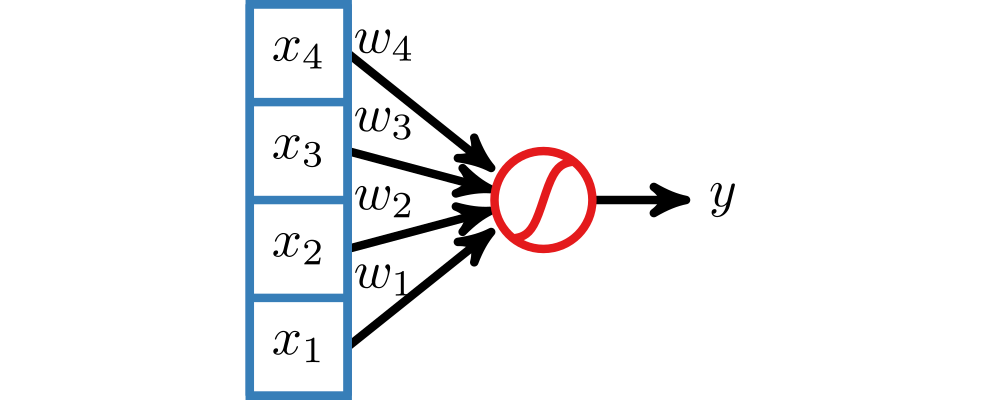

In [35]:
%%tikz -l arrows -s 1000,400 -sc 0.65 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}
  
\foreach \i in {1,2,3,4} {
    \draw[->, >=stealth', ultra thick, color=black] (1,\i-2.5) -- (2.5,\i*0.2-0.5) node [near start, above] {$w_\i$};
    \node[] at (0.5,\i-2.5) {$x_\i$};     
}

\draw[->, >=stealth', ultra thick] (3.5,0) -- (4.5,0);
  
%input      
\draw[ultra thick, color=nice-blue] (0,-2) grid (1,2);
\draw[ultra thick, color=nice-blue] (0,-2) rectangle (1,2);

%non-linearities
\begin{scope}[shift={(3,0)},scale=1.0, local bounding box=sigmoid]
    \draw[ultra thick, yshift=-0.5cm, color=nice-red] plot [domain=-0.3:0.3](\x, {(0.8/(1+exp(-15*\x))+0.1)});
    \draw[ultra thick, color=nice-red] (0,0) circle (0.5cm);
\end{scope}        
      
\node[anchor = west] at (4.5,0) {$y$};

## Multiple Neurons
Let us assume we have two neurons:
\begin{align}
y_1 &= \text{sigmoid}(\mathbf{w}^T_1 \mathbf{x} + b_1)\\
y_2 &= \text{sigmoid}(\mathbf{w}^T_2\mathbf{x} + b_2)
\end{align}

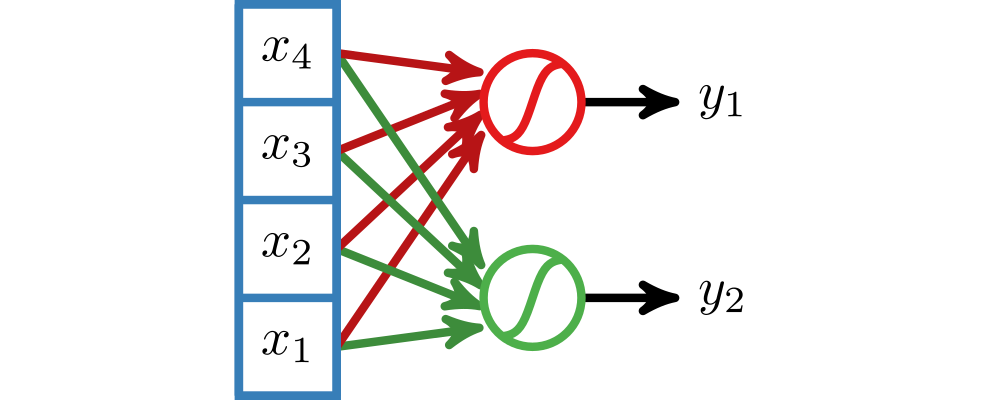

In [41]:
%%tikz -l arrows -s 1000,400 -sc 0.65 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}
    
\foreach \i in {1,2,3,4} {
    \draw[->, >=stealth', ultra thick, color=black!20!nice-green] (1,\i-2.5) -- (2.5,\i*0.2-1.5);
    \node[] at (0.5,\i-2.5) {$x_\i$};     
    \draw[->, >=stealth', ultra thick, color=black!20!nice-red] (1,\i-2.5) -- (2.5,\i*0.2+0.5);
}

\draw[->, >=stealth', ultra thick] (3.5,1) -- (4.5,1);
\draw[->, >=stealth', ultra thick] (3.5,-1) -- (4.5,-1);       
  
%input
\draw[ultra thick, color=nice-blue] (0,-2) grid (1,2);
\draw[ultra thick, color=nice-blue] (0,-2) rectangle (1,2);
      
%non-linearities
\begin{scope}[shift={(3,1)},scale=1.0]
    \draw[ultra thick, yshift=-0.5cm, color=nice-red] plot [domain=-0.3:0.3](\x, {(0.8/(1+exp(-15*\x))+0.1)});
    \draw[ultra thick, color=nice-red] (0,0) circle (0.5cm);
\end{scope} 

\begin{scope}[shift={(3,-1)},scale=1.0]
    \draw[ultra thick, yshift=-0.5cm, color=nice-green] plot [domain=-0.3:0.3](\x, {(0.8/(1+exp(-15*\x))+0.1)});
    \draw[ultra thick, color=nice-green] (0,0) circle (0.5cm);
\end{scope}  
   
\node[anchor = west] at (4.5,1) {$y_1$};
\node[anchor = west] at (4.5,-1) {$y_2$};   

## Multiple Neurons
We will write this more compactly as a function $f_\theta: \mathbb{R}^4 \to \mathbb{R}^2$
\begin{align}
\mathbf{y} &= \text{sigmoid}(\mathbf{W}\mathbf{x} + \mathbf{b}) \quad\text{ with } \mathbf{W}\in\mathbb{R}^{2\times4}, \mathbf{b}\in\mathbb{R}^{2}
\end{align}

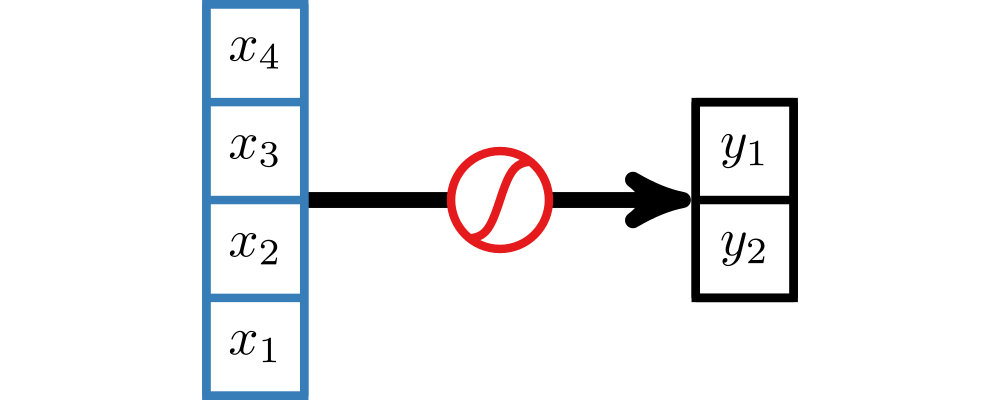

In [47]:
%%tikz -l arrows -s 1000,400 -sc 0.65 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}



\draw[->, >=stealth', line width=3pt, color=black] (1,0) -- (4.95,0);    

%inputs
\draw[ultra thick, color=nice-blue] (0,-2) grid (1,2);
\draw[ultra thick, color=nice-blue] (0,-2) rectangle (1,2);
      
%outputs      
\draw[ultra thick, color=black] (5,-1) grid (6,1);          
\draw[ultra thick, color=black] (5,-1) rectangle (6,1);              
      
%non-linearities
\begin{scope}[shift={(3,0)},scale=1.0]
    \draw[ultra thick, color=nice-red, fill=white] (0,0) circle (0.5cm);      
    \draw[ultra thick, yshift=-0.5cm, color=nice-red, fill=white] plot [domain=-0.3:0.3](\x, {(0.8/(1+exp(-15*\x))+0.1)});
\end{scope}    

\foreach \i in {1,2,3,4} {
    \node[] at (0.5,\i-2.5) {$x_\i$};     
}

\foreach \i in {1,2} {
    \node[] at (5.5,1-\i+0.5) {$y_\i$};     
}



## Forward Propagation
\begin{align}
\mathbf{y} &= \text{sigmoid}(\mathbf{W}\mathbf{x} + \mathbf{b}) \quad\text{ with } \mathbf{W}\in\mathbb{R}^{2\times4}, \mathbf{b}\in\mathbb{R}^{2}
\end{align}

In [84]:
np.random.seed(1337)

def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

W = np.random.rand(2, 4)
b = np.random.rand(2)
x = [0.5, 0.2, -0.3, 0.2]

y = sigmoid(W @ x + b)

y

array([ 0.71176857,  0.62153938])

## Stochastic Gradient Descent

As the model $f_\theta(x)$ is differentiable with respect to parameters $\theta$, we can use any continuous optimization method, for instance Stochastic Gradient Descent, to minimize the loss function $\mathcal{L}$.

1. Initialize parameters $\theta$
2. Shuffle training data $\mathcal{T}$
  - For every example $(x_i,y_i) \in \mathcal{T}$ 
    1. Find direction of parameters that improves loss by calculating $\frac{\partial \mathcal{L}(f_\theta, x_i, y_i)}{\partial \theta}$
    2. Update parameters with learning rate $\alpha$  
      $\theta := \theta - \alpha*\frac{\partial \mathcal{L}(f_\theta, x_i, y_i)}{\partial \theta}$
  - Go to 2.    
    

<img  src="https://upload.wikimedia.org/wikipedia/commons/6/68/Gradient_ascent_%28surface%29.png" width=1000/>
Source: Wikipedia

## Momentum-based Optimizers
<img  src="http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif" width=1000/>

## Example: Logistic Regression

# A Modular Approach

## Multi-layer Perceptron

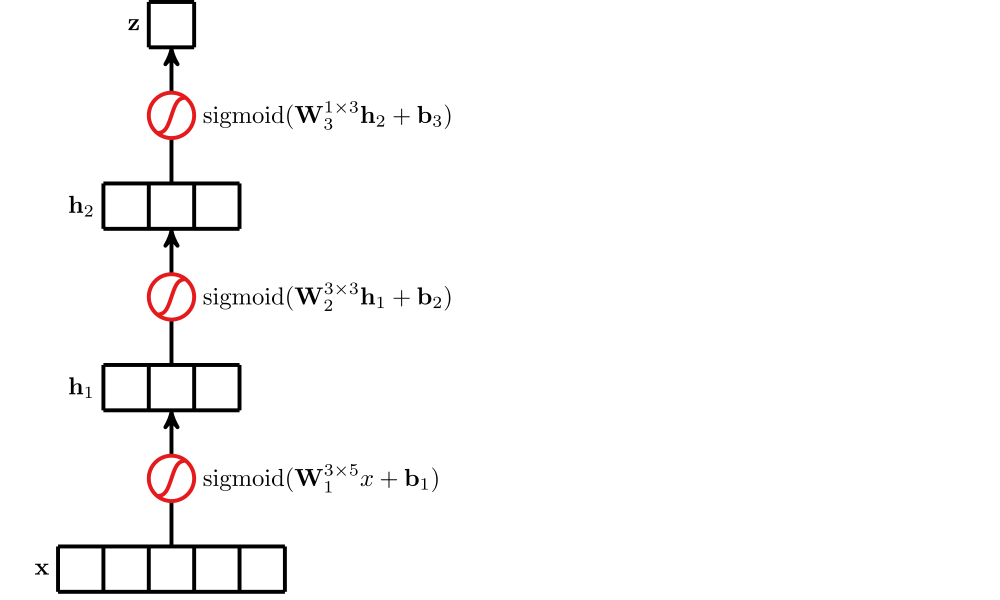

In [189]:
%%tikz -l arrows -s 1000,600 -sc 0.65 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

%x
\draw[ultra thick] (0,0) grid (5,1);
\node[anchor = east] at (0,0.5) {$\mathbf{x}$};
\draw[->, >=stealth', ultra thick] (2.5,1) -- (2.5,4);
\begin{scope}[shift={(2.5,2.5)},scale=1.0]
    \draw[ultra thick, color=nice-red, fill=white] (0,0) circle (0.5cm);
    \draw[ultra thick, yshift=-0.5cm, color=nice-red] plot [domain=-0.3:0.3](\x, {(0.8/(1+exp(-15*\x))+0.1)});
\end{scope}    
\node[anchor=west] at (3,2.5) {sigmoid$(\mathbf{W}^{3\times 5}_1x+\mathbf{b}_1)$};
      
%1st hidden layer
\draw[ultra thick] (1,4) grid (4,5);
\node[anchor = east] at (1.0,4.5) {$\mathbf{h}_1$};      
\draw[->, >=stealth', ultra thick] (2.5,5) -- (2.5,8);      
\begin{scope}[shift={(2.5,6.5)},scale=1.0]
    \draw[ultra thick, color=nice-red, fill=white] (0,0) circle (0.5cm);
    \draw[ultra thick, yshift=-0.5cm, color=nice-red] plot [domain=-0.3:0.3](\x, {(0.8/(1+exp(-15*\x))+0.1)});
\end{scope}         
\node[anchor=west] at (3,6.5) {sigmoid$(\mathbf{W}^{3\times 3}_2\mathbf{h}_1+\mathbf{b}_2)$};
      
%2nd hidden layer
\draw[ultra thick] (1,8) grid (4,9);
\node[anchor = east] at (1.0,8.5) {$\mathbf{h}_2$};            
\draw[->, >=stealth', ultra thick] (2.5,9) -- (2.5,12);            
\begin{scope}[shift={(2.5,10.5)},scale=1.0]
    \draw[ultra thick, color=nice-red, fill=white] (0,0) circle (0.5cm);
    \draw[ultra thick, yshift=-0.5cm, color=nice-red] plot [domain=-0.3:0.3](\x, {(0.8/(1+exp(-15*\x))+0.1)});
\end{scope}         
\node[anchor=west] at (3,10.5) {sigmoid$(\mathbf{W}^{1\times 3}_3\mathbf{h}_2+\mathbf{b}_3)$};  
      
%output
\draw[ultra thick] (2,12) grid (3,13);
\node[anchor = east] at (2.0,12.5) {$\mathbf{z}$};            

%dummy node for left align      
\node[] at (20,0) {};

## Outline
- Backpropagation and Stochastic Gradient Descent
- <span class="red">A Modular Approach</span>
  - Linear Algebra Operations
  - Activation Functions
  - Gradient Checking
- TensorFlow: A Deep Learning Library
- Regularization
  - Dropout
  - Gradient Clipping
- Recurrent Neural Networks
  - Long Short-term Memory (LSTM)
  - Gated Recurrent Unit (GRU)
- Attention

<div class=right><div class=top><div class=small>
<div style="margin-bottom: 60%;"></div>
\begin{align}
f_{1,\theta} &: \mathbb{R}^5 \to \mathbb{R}^3\\
f_{2,\theta} &: \mathbb{R}^3 \to \mathbb{R}^3\\
f_{3,\theta} &: \mathbb{R}^3 \to \mathbb{R}^1\\
g_\theta &= f_{3,\theta} \circ f_{2,\theta} \circ f_{1,\theta}\\
g_\theta(\mathbf{x}) &= f_{3,\theta}(f_{2,\theta}(f_{1,\theta}(\mathbf{x})))\\
g_\theta &: \mathbb{R}^5 \to \mathbb{R}^1
\end{align}
</div>
</div>

## Calculation of Gradients
<br>
<div class=verysmall>
\begin{align}
g_\theta(\mathbf{x}) &= \text{sigmoid}(\mathbf{W}^{1\times 3}_3\text{sigmoid}(\mathbf{W}^{3\times 3}_2\text{sigmoid}(\mathbf{W}^{3\times 5}_1\mathbf{x}+\mathbf{b}_1)+\mathbf{b}_2)+\mathbf{b}_3)\\
\frac{\partial \mathcal{L}(f_\theta, \mathbf{x}, \mathbf{y})}{\partial \mathbf{W}^{1\times 3}_3} &= \text{ ?}\\
\frac{\partial \mathcal{L}(f_\theta, \mathbf{x}, \mathbf{y})}{\partial \mathbf{b}_3} &= \text{ ?}\\
\frac{\partial \mathcal{L}(f_\theta, \mathbf{x}, \mathbf{y})}{\partial \mathbf{W}^{3\times 3}_2} &= \text{ ?}\\
\frac{\partial \mathcal{L}(f_\theta, \mathbf{x}, \mathbf{y})}{\partial \mathbf{b}_2} &= \text{ ?}\\
\frac{\partial \mathcal{L}(f_\theta, \mathbf{x}, \mathbf{y})}{\partial \mathbf{W}^{3\times 5}_1} &= \text{ ?}\\
\frac{\partial \mathcal{L}(f_\theta, \mathbf{x}, \mathbf{y})}{\partial \mathbf{b}_1} &= \text{ ?}
\end{align}
</div>

## Chain Rule

\begin{align}
\frac{\partial f \circ g}{\partial \theta} &= \frac{\partial f \circ g}{\partial g} \frac{\partial g}{\partial \theta}\\
\end{align}

## Example

<div class=small>
\begin{align}
\frac{\partial \mathcal{L}(\text{sigmoid}(\mathbf{W}\mathbf{x}),\mathbf{y})}{\partial \mathbf{W}} &= \frac{\partial \mathcal{L}(\text{sigmoid}(\mathbf{W}\mathbf{x}),\mathbf{y})}{\partial \text{ sigmoid}(\mathbf{W}\mathbf{x})} \frac{\partial \text{ sigmoid}(\mathbf{W}\mathbf{x})}{\partial \mathbf{Wx}} \frac{\partial{\mathbf{Wx}}}{\partial\mathbf{W}}
\end{align}
</div>

\begin{align}
\mathbf{h} &= \mathbf{W}\mathbf{x}\\
\mathbf{z} &= \text{sigmoid}(\mathbf{h})\\
\mathcal{L}(\mathbf{z},\mathbf{y}) &= \frac{1}{2}||\mathbf{z} - \mathbf{y}||^2
\end{align}

\begin{align}
\frac{\mathcal{\partial \frac{1}{2}||\mathbf{z} - \mathbf{y}||^2}}{\partial \mathbf{W}} &= \frac{\partial \frac{1}{2}||\mathbf{z} - \mathbf{y}||^2}{\partial\mathbf{z}} \frac{\partial\mathbf{z}}{\partial \mathbf{h}} \frac{\partial \mathbf{h}}{\partial \mathbf{W}}
\end{align}

## Example cont.

\begin{align}
\mathbf{h} &= \mathbf{W}\mathbf{x}\\
\mathbf{z} &= \text{sigmoid}(\mathbf{h})\\
\mathcal{L}(\mathbf{z},\mathbf{y}) &= \frac{1}{2}||\mathbf{z} - \mathbf{y}||^2
\end{align}

\begin{align}
\frac{\mathcal{\partial \frac{1}{2}||\mathbf{z} - \mathbf{y}||^2}}{\partial \mathbf{W}} &= \frac{\partial \frac{1}{2}||\mathbf{z} - \mathbf{y}||^2}{\partial\mathbf{z}} \frac{\partial\mathbf{z}}{\partial \mathbf{h}} \frac{\partial \mathbf{h}}{\partial \mathbf{W}}\\
\partial \mathbf{z} &= \mathbf{z}-\mathbf{y}\\
\partial \mathbf{h} &= \partial \mathbf{z}\,\text{sigmoid}(\mathbf{h})\,(1 - \text{sigmoid}(\mathbf{h}))\\
\partial \mathbf{W} &= \partial\mathbf{h}\otimes\mathbf{x}
\end{align}

## Module

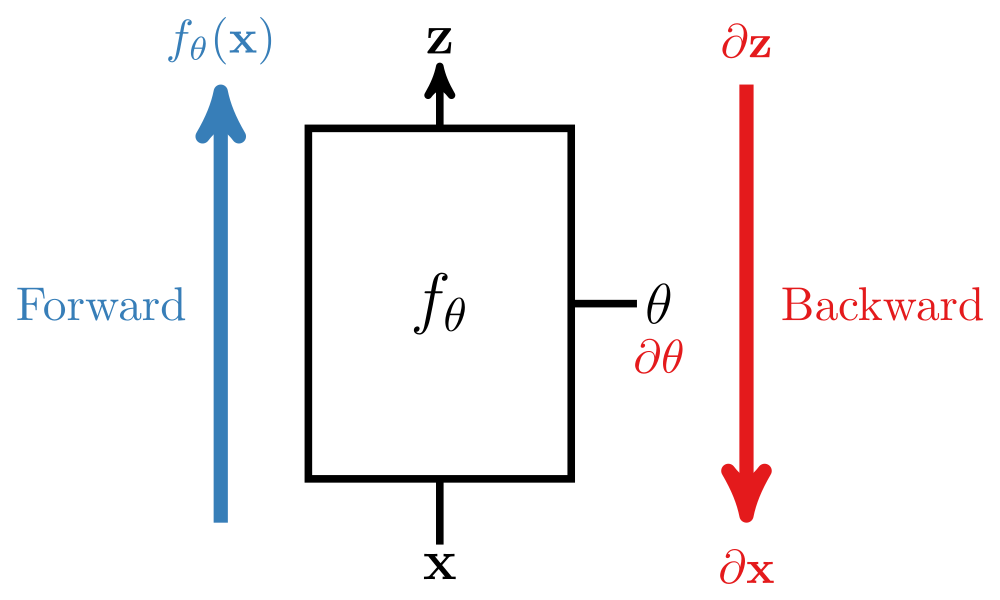

In [17]:
%%tikz -l arrows -s 1000,600 -sc 0.65 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

\draw[->, >=stealth', ultra thick] (1.5,-0.75) -- (1.5,4.75);
\draw[ultra thick, fill=white] (0,0) rectangle (3,4);
\node[font=\large] at (1.5, 5) {$\mathbf{z}$};
\node[font=\large] at (1.5, -1) {$\mathbf{x}$};
\node[font=\Large] at (1.5, 2) {$f_\theta$};
\node[font=\large] at (4, 2) {$\theta$};
\draw[ultra thick] (3,2) -- (3.75,2);
      
\draw[->, >=stealth', line width=3pt, nice-blue] (-1,-0.5) -- (-1,4.5);
\node[anchor=east, nice-blue] at (-1.2,2) {Forward};
\node[nice-blue] at (-1,5) {$f_\theta(\mathbf{x})$};      
\draw[->, >=stealth', line width=3pt, nice-red] (5,4.5) -- (5,-0.5);

\node[anchor=west, nice-red] at (5.2,2) {Backward};

\node[color=nice-red] at (5,5) {$\partial\mathbf{z}$};      
\node[color=nice-red] at (4,1.4) {$\partial\theta$};     
\node[color=nice-red] at (5,-1) {$\partial\mathbf{x}$};      
      
      
%dummy node
\node[] at (6,0) {};
            

## Backpropagation

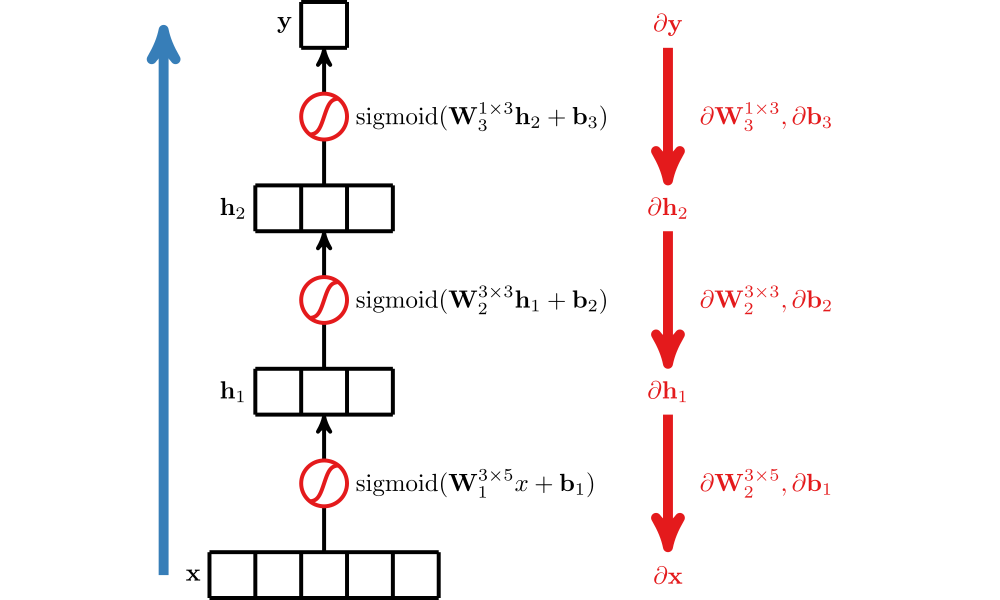

In [42]:
%%tikz -l arrows -s 1000,600 -sc 0.65 -f svg

\definecolor{nice-red}{HTML}{E41A1C}
\definecolor{nice-orange}{HTML}{FF7F00}
\definecolor{nice-yellow}{HTML}{FFC020}
\definecolor{nice-green}{HTML}{4DAF4A}
\definecolor{nice-blue}{HTML}{377EB8}
\definecolor{nice-purple}{HTML}{984EA3}

%x
\draw[ultra thick] (0,0) grid (5,1);
\node[anchor = east] at (0,0.5) {$\mathbf{x}$};
\draw[->, >=stealth', ultra thick] (2.5,1) -- (2.5,4);
\begin{scope}[shift={(2.5,2.5)},scale=1.0]
    \draw[ultra thick, color=nice-red, fill=white] (0,0) circle (0.5cm);
    \draw[ultra thick, yshift=-0.5cm, color=nice-red] plot [domain=-0.3:0.3](\x, {(0.8/(1+exp(-15*\x))+0.1)});
\end{scope}    
\node[anchor=west] at (3,2.5) {sigmoid$(\mathbf{W}^{3\times 5}_1x+\mathbf{b}_1)$};
      
%1st hidden layer
\draw[ultra thick] (1,4) grid (4,5);
\node[anchor = east] at (1.0,4.5) {$\mathbf{h}_1$};      
\draw[->, >=stealth', ultra thick] (2.5,5) -- (2.5,8);      
\begin{scope}[shift={(2.5,6.5)},scale=1.0]
    \draw[ultra thick, color=nice-red, fill=white] (0,0) circle (0.5cm);
    \draw[ultra thick, yshift=-0.5cm, color=nice-red] plot [domain=-0.3:0.3](\x, {(0.8/(1+exp(-15*\x))+0.1)});
\end{scope}         
\node[anchor=west] at (3,6.5) {sigmoid$(\mathbf{W}^{3\times 3}_2\mathbf{h}_1+\mathbf{b}_2)$};
      
%2nd hidden layer
\draw[ultra thick] (1,8) grid (4,9);
\node[anchor = east] at (1.0,8.5) {$\mathbf{h}_2$};            
\draw[->, >=stealth', ultra thick] (2.5,9) -- (2.5,12);            
\begin{scope}[shift={(2.5,10.5)},scale=1.0]
    \draw[ultra thick, color=nice-red, fill=white] (0,0) circle (0.5cm);
    \draw[ultra thick, yshift=-0.5cm, color=nice-red] plot [domain=-0.3:0.3](\x, {(0.8/(1+exp(-15*\x))+0.1)});
\end{scope}         
\node[anchor=west] at (3,10.5) {sigmoid$(\mathbf{W}^{1\times 3}_3\mathbf{h}_2+\mathbf{b}_3)$};  
      
%output
\draw[ultra thick] (2,12) grid (3,13);
\node[anchor = east] at (2.0,12.5) {$\mathbf{y}$};            
      
\draw[->, >=stealth', line width=4pt, color=nice-blue] (-1,0.5) -- (-1,12.5);  
%\node[anchor=east, nice-blue, font=\large, text width=5em] at (-1,7) {Forward};   
      
\draw[->, >=stealth', line width=4pt, color=nice-red] (10,12) -- (10,9);  
\node[nice-red] at (10,12.5) {$\partial\mathbf{y}$};      
\node[nice-red] at (10,8.5) {$\partial\mathbf{h}_2$};      
\node[anchor=west, nice-red] at (10.5,10.5) {$\partial\mathbf{W}^{1 \times 3}_3, \partial\mathbf{b}_3$};      
\draw[->, >=stealth', line width=4pt, color=nice-red] (10,8) -- (10,5);  
\node[nice-red] at (10,4.5) {$\partial\mathbf{h}_1$};      
\node[anchor=west, nice-red] at (10.5,6.5) {$\partial\mathbf{W}^{3 \times 3}_2, \partial\mathbf{b}_2$};      
\draw[->, >=stealth', line width=4pt, color=nice-red] (10,4) -- (10,1);  
\node[nice-red] at (10,0.5) {$\partial\mathbf{x}$};      
\node[anchor=west, nice-red] at (10.5,2.5) {$\partial\mathbf{W}^{3 \times 5}_2, \partial\mathbf{b}_1$};      

       

## Deep Learning Libraries
- Torch7
- Wolfe
- Theano
- DeepLearning4J
- autograd
- TensorFlow
- ...

<img  src="tensorflow.jpg"/>

## Logistic Regression

In [601]:
import tensorflow as tf
seed = 0
#input
x = tf.placeholder("float")
#parameters
W = tf.Variable(tf.random_uniform([1,3], -0.1, 0.1, seed=seed))
b = tf.Variable(tf.zeros([1,1]))
#f_theta
z = tf.nn.sigmoid(tf.matmul(W,x) + b) #sigmoid(Wx + b)

In [604]:
sess = tf.Session()
sess.run(tf.initialize_all_variables()) #initialize W and b
sess.run(W)

array([[ 0.06253929, -0.08428507,  0.0783371 ]], dtype=float32)

In [605]:
sess.run(b)

array([[ 0.]], dtype=float32)

## Logistic Regression cont.

Forward: $\mathbf{z} = f_\theta(\mathbf{x})$

In [609]:
sess.run(z, feed_dict={x: [[-5.5],[2.0],[-0.5]]})

array([[ 0.5596692]], dtype=float32)

Backward: $\partial\mathbf{W},\partial\mathbf{b},\partial\mathbf{x}$ given upstream gradient $\partial\mathbf{z}$

In [611]:
sess.run(tf.initialize_all_variables())
gradz = [[0.1]] 
grad = tf.gradients(z,[W, b, x], grad_ys=gradz)
sess.run(grad, feed_dict={x: [[-5.5],[2.0],[-0.5]]})

[array([[-0.13228811,  0.04810477, -0.01202619]], dtype=float32),
 array([[ 0.02405239]], dtype=float32),
 array([[ -1.91455160e-03],
        [ -5.02410170e-04],
        [  7.70968909e-05]], dtype=float32)]

## Logistic Regression cont.

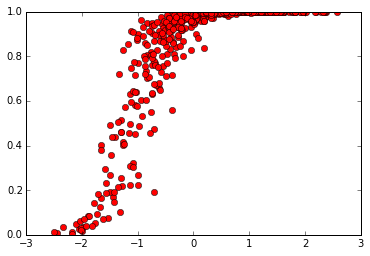

In [363]:
import matplotlib.pyplot as plt
%matplotlib inline 

N = 500 #number of training examples
X = np.random.uniform(-1,1,size=[N,3]) #input data
Y = list()
for i in range(N):
    ex = X[i]
    Y.append(1 / (1 + np.exp(-sum(ex)*3.5 - 4.0 + np.random.normal(0.05))))

Xsum = sum(X, axis=1)
plt.plot(Xsum, Y, 'ro')
plt.show()    

## Logistic Regression cont.

In [364]:
y = tf.placeholder("float")
cost = tf.nn.l2_loss(y-z) # 1/2 * ||f(x)-y||^2
optimizer = tf.train.AdamOptimizer(0.1).minimize(cost) 

In [385]:
numEpochs = 10
sess.run(tf.initialize_all_variables()) #initialize W, b and Adam optimizer
for epoch in range(numEpochs): # for every epoch
    for i in range(N): # for every training example
        x_in = np.transpose([X[i]]) # input
        fx = Y[i] # expected output            
        sess.run(optimizer, feed_dict={x: x_in, y: fx})
    if epoch % 2 == 0:
        print "Epoch:", '%04d' % (epoch+1), "cost =", \
        sess.run(cost, feed_dict={x: x_in, y: fx})
print "Optimization Finished! final cost =", sess.run(cost, feed_dict={x: x_in, y: fx})

Epoch: 0001 cost = 6.54066e-06
Epoch: 0003 cost = 1.33362e-10
Epoch: 0005 cost = 5.71885e-08
Epoch: 0007 cost = 8.72904e-08
Epoch: 0009 cost = 9.71419e-08
Optimization Finished! final cost = 9.91754e-08


## Logistic Regression cont.

In [380]:
W_trained = sess.run(W)
b_trained = sess.run(b)
[W_trained, b_trained]

[array([[ 2.84354281,  2.85930395,  2.77622414]], dtype=float32),
 array([[ 4.24783564]], dtype=float32)]

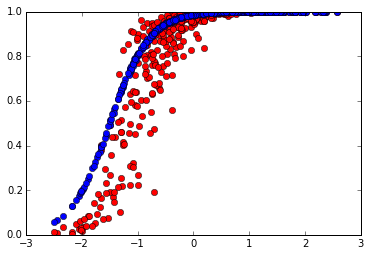

In [379]:
pred = list()
for i in range(N):
    x_in = np.transpose([X[i]]) # input
    fx = sess.run(z, feed_dict={x: x_in})
    pred.append(fx[0][0])
    
plt.plot(Xsum, Y, 'ro', Xsum, pred, 'bo')
plt.show()  

## Multi-layer Perceptron

In [397]:
#input
x = tf.placeholder("float")
#parameters
W1 = tf.Variable(tf.random_uniform([3,5], seed=seed))
b1 = tf.Variable(tf.zeros([3,1]))
W2 = tf.Variable(tf.random_uniform([3,3], seed=seed))
b2 = tf.Variable(tf.zeros([3,1]))
W3 = tf.Variable(tf.random_uniform([1,3], seed=seed))
b3 = tf.Variable(tf.zeros([1,1]))
#model
h1 = tf.nn.sigmoid(tf.matmul(W1,x) + b1) 
h2 = tf.nn.sigmoid(tf.matmul(W2,h1) + b2)
mlp_z = tf.nn.sigmoid(tf.matmul(W3,h2) + b3) 

sess.run(tf.initialize_all_variables())
sess.run(mlp_z, feed_dict={x: [[-5.5], [2.0], [-0.5], [2.0], [4.0]]})

array([[ 0.79723024]], dtype=float32)

## Background Material
- Stanford Course on [Deep Learning for Natural Language Processing](http://cs224d.stanford.edu/syllabus.html)

## References